# Download databases
https://github.com/ventolab/CellphoneDB/blob/master/notebooks/T0_DownloadDB.ipynb

In [107]:
import pandas as pd
import glob
import os
from IPython.display import HTML, display
from cellphonedb.utils import db_releases_utils

display(HTML(db_releases_utils.get_remote_database_versions_html()['db_releases_html_table']))

In [108]:
# -- Version of the databse
cpdb_version = 'v4.1.0'
# -- Path where the input files to generate the database are located
cpdb_target_dir = os.path.join('C:/Users/heung/OneDrive/Documents/scData/CellPhoneDB/', cpdb_version)

In [109]:
from cellphonedb.utils import db_utils

db_utils.download_database(cpdb_target_dir, cpdb_version)

Downloaded cellphonedb.zip into C:/Users/heung/OneDrive/Documents/scData/CellPhoneDB/v4.1.0
Downloaded complex_input.csv into C:/Users/heung/OneDrive/Documents/scData/CellPhoneDB/v4.1.0
Downloaded gene_input.csv into C:/Users/heung/OneDrive/Documents/scData/CellPhoneDB/v4.1.0
Downloaded interaction_input.csv into C:/Users/heung/OneDrive/Documents/scData/CellPhoneDB/v4.1.0
Downloaded protein_input.csv into C:/Users/heung/OneDrive/Documents/scData/CellPhoneDB/v4.1.0
Downloaded uniprot_synonyms.tsv into C:/Users/heung/OneDrive/Documents/scData/CellPhoneDB/v4.1.0\sources


---
# Making cellphonedb input files
> metadata

In [16]:
import scanpy as sc
import pandas as pd

In [15]:
adata = sc.read(folder_path + '16. Siglec-9_GSE235913/concat/adata_subset.h5ad')

In [18]:
# cell ID와 cell_type 열 추출
df = adata.obs[['cell_type']].copy()

# Cell_id를 column에 추가
df['cell_id'] = df.index

# column reorder
df = df[['cell_id', 'cell_type']]

# save
df.to_csv(folder_path + '16. Siglec-9_GSE235913/concat/metadata.tsv', sep = '\t', index=False)

---
# Run CellPhoneDB method 2

### Check python vesion

In [8]:
import pandas as pd
import sys
import os

pd.set_option('display.max_columns', 100)
# Define our base dirctory for the analysis
# os.chdir('/home/jsw/cpdb')

In [9]:
print(sys.version)

3.11.9 | packaged by conda-forge | (main, Apr 19 2024, 18:27:10) [MSC v.1938 64 bit (AMD64)]


### load files

In [13]:
folder_path = "C:/Users/heung/OneDrive/Documents/scData/"

In [38]:
cpdb_file_path = folder_path + 'CellPhoneDB/v5.0.0/cellphonedb.zip'
meta_file_path = folder_path + "16. Siglec-9_GSE235913/concat/metadata.tsv"
counts_file_path = folder_path + '16. Siglec-9_GSE235913/concat/adata_subset2.h5ad'
out_path = folder_path + '16. Siglec-9_GSE235913/concat/'


### inspect input files

In [21]:
metadata = pd.read_csv(meta_file_path, sep = '\t')
metadata.head(3)

,cell_id,cell_type
0,GTCATTTGTAAGGATT-1,Monocytic cells
1,CTTCTAACATGGAGAC-1,Oligodendrocytes
2,GAACATCGTGGTCTCG-1,T cells


In [24]:
import anndata

adata = anndata.read_h5ad(counts_file_path)
adata.shape

(55660, 34234)

In [26]:
# metadata의 바코드와 counts의 바코드가 일치하는지 확인
list(adata.obs.index).sort() == list(metadata['cell_id']).sort()

True

---
# Run statistical analysis

In [36]:
adata.X = adata.layers['scvi_normalized']

In [37]:
adata.write_h5ad(out_path + 'adata_subset2.h5ad')

In [39]:
from cellphonedb.src.core.methods import cpdb_statistical_analysis_method

cpdb_results = cpdb_statistical_analysis_method.call(
    cpdb_file_path = cpdb_file_path,
    meta_file_path = meta_file_path,
    counts_file_path = counts_file_path,
    counts_data = 'hgnc_symbol',
    output_path = out_path
)

Reading user files...
The following user files were loaded successfully:
C:/Users/heung/OneDrive/Documents/scData/16. Siglec-9_GSE235913/concat/adata_subset2.h5ad
C:/Users/heung/OneDrive/Documents/scData/16. Siglec-9_GSE235913/concat/metadata.tsv
[ ][CORE][18/07/24-14:59:09][INFO] [Cluster Statistical Analysis] Threshold:0.1 Iterations:1000 Debug-seed:-1 Threads:4 Precision:3
[ ][CORE][18/07/24-14:59:12][INFO] Running Real Analysis
[ ][CORE][18/07/24-14:59:12][INFO] Running Statistical Analysis


100%|██████████| 1000/1000 [04:31<00:00,  3.68it/s]

[ ][CORE][18/07/24-15:03:43][INFO] Building Pvalues result


[ ][CORE][18/07/24-15:03:44][INFO] Building results
Saved deconvoluted to C:/Users/heung/OneDrive/Documents/scData/16. Siglec-9_GSE235913/concat/statistical_analysis_deconvoluted_07_18_2024_150344.txt
Saved deconvoluted_percents to C:/Users/heung/OneDrive/Documents/scData/16. Siglec-9_GSE235913/concat/statistical_analysis_deconvoluted_percents_07_18_2024_150344.txt
Saved means to C:/Users/heung/OneDrive/Documents/scData/16. Siglec-9_GSE235913/concat/statistical_analysis_means_07_18_2024_150344.txt
Saved pvalues to C:/Users/heung/OneDrive/Documents/scData/16. Siglec-9_GSE235913/concat/statistical_analysis_pvalues_07_18_2024_150344.txt
Saved significant_means to C:/Users/heung/OneDrive/Documents/scData/16. Siglec-9_GSE235913/concat/statistical_analysis_significant_means_07_18_2024_150344.txt


---
# Visualization

In [29]:
import os
import anndata as ad
import pandas as pd
import ktplotspy as kpy
import matplotlib.pyplot as plt
%matplotlib inline

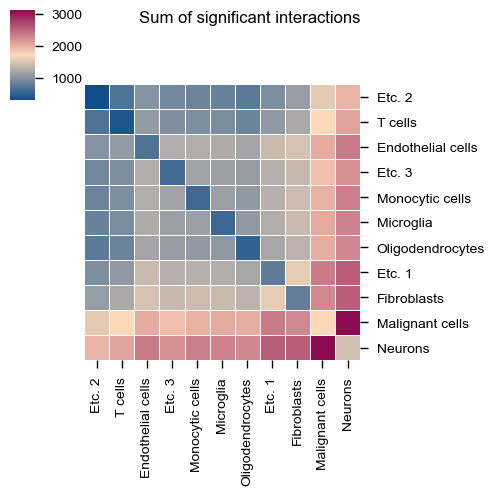

In [49]:
kpy.plot_cpdb_heatmap(
    pvals = cpdb_results['pvalues'],
    degs_analysis = False,
    figsize = (5, 5),
    title = "Sum of significant interactions"
)

In [84]:
ic_list = ['CD27', 'CD28', 'CD40', 'IL2RB', 'TNFRSF9', 'TNFRSF4', 'TNFRSF18', 'ICOS',
            'ADORA2A', 'ADORA2B', 'CD276' 'VTCN1', 'BTLA', 'CTLA4', 'IDO1', 'KIR3DL1', 'NOX2', 'PDCD1', 'CD274', 'PDCD1LG2', 'HAVCR2', 'VSIR', 'SIGLEC7', 'SIGLEC9']

In [82]:
'SIGLEC9' in adata.var_names

True

In [91]:
df = cpdb_results['pvalues']

In [104]:
filtered_df = df[df['gene_a'].isin(ic_list) | df['gene_b'].isin(ic_list)]
filtered_df.shape

(29, 134)

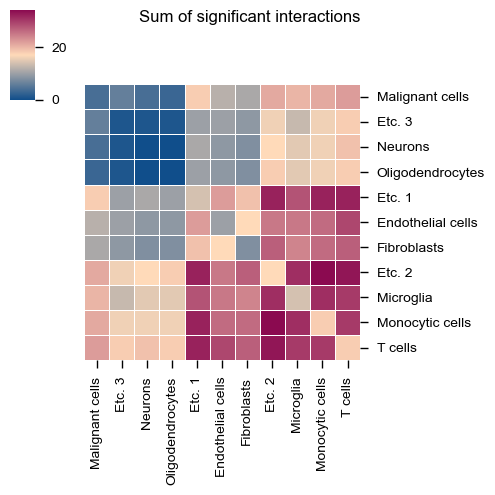

In [105]:
kpy.plot_cpdb_heatmap(pvals = filtered_df,
                      degs_analysis = False,
                      figsize = (5, 5),
                      title = "Sum of significant interactions")

In [106]:
filtered_df

,id_cp_interaction,interacting_pair,partner_a,partner_b,gene_a,gene_b,secreted,receptor_a,receptor_b,annotation_strategy,is_integrin,directionality,classification,Endothelial cells|Endothelial cells,Endothelial cells|Etc. 1,Endothelial cells|Etc. 2,Endothelial cells|Etc. 3,Endothelial cells|Fibroblasts,Endothelial cells|Malignant cells,Endothelial cells|Microglia,Endothelial cells|Monocytic cells,Endothelial cells|Neurons,Endothelial cells|Oligodendrocytes,Endothelial cells|T cells,Etc. 1|Endothelial cells,Etc. 1|Etc. 1,Etc. 1|Etc. 2,Etc. 1|Etc. 3,Etc. 1|Fibroblasts,Etc. 1|Malignant cells,Etc. 1|Microglia,Etc. 1|Monocytic cells,Etc. 1|Neurons,Etc. 1|Oligodendrocytes,Etc. 1|T cells,Etc. 2|Endothelial cells,Etc. 2|Etc. 1,Etc. 2|Etc. 2,Etc. 2|Etc. 3,Etc. 2|Fibroblasts,Etc. 2|Malignant cells,Etc. 2|Microglia,Etc. 2|Monocytic cells,Etc. 2|Neurons,Etc. 2|Oligodendrocytes,Etc. 2|T cells,Etc. 3|Endothelial cells,Etc. 3|Etc. 1,Etc. 3|Etc. 2,Etc. 3|Etc. 3,...,Microglia|Malignant cells,Microglia|Microglia,Microglia|Monocytic cells,Microglia|Neurons,Microglia|Oligodendrocytes,Microglia|T cells,Monocytic cells|Endothelial cells,Monocytic cells|Etc. 1,Monocytic cells|Etc. 2,Monocytic cells|Etc. 3,Monocytic cells|Fibroblasts,Monocytic cells|Malignant cells,Monocytic cells|Microglia,Monocytic cells|Monocytic cells,Monocytic cells|Neurons,Monocytic cells|Oligodendrocytes,Monocytic cells|T cells,Neurons|Endothelial cells,Neurons|Etc. 1,Neurons|Etc. 2,Neurons|Etc. 3,Neurons|Fibroblasts,Neurons|Malignant cells,Neurons|Microglia,Neurons|Monocytic cells,Neurons|Neurons,Neurons|Oligodendrocytes,Neurons|T cells,Oligodendrocytes|Endothelial cells,Oligodendrocytes|Etc. 1,Oligodendrocytes|Etc. 2,Oligodendrocytes|Etc. 3,Oligodendrocytes|Fibroblasts,Oligodendrocytes|Malignant cells,Oligodendrocytes|Microglia,Oligodendrocytes|Monocytic cells,Oligodendrocytes|Neurons,Oligodendrocytes|Oligodendrocytes,Oligodendrocytes|T cells,T cells|Endothelial cells,T cells|Etc. 1,T cells|Etc. 2,T cells|Etc. 3,T cells|Fibroblasts,T cells|Malignant cells,T cells|Microglia,T cells|Monocytic cells,T cells|Neurons,T cells|Oligodendrocytes,T cells|T cells
383,CPI-CS056D84EB8,Adenosine_byNT5E_and_SLC29A1_ADORA2A,complex:Adenosine_byNT5E_and_SLC29A1,simple:P29274,NaN,ADORA2A,True,False,True,curated,False,Ligand-Receptor,Signaling by Adenosine,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,0.891,1.000,0.998,1.000,1.000,1.000,1.000,1.000,0.974,1.000,1.000,1.000,1.000,...,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.0,1.000,1.000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000,1.000,1.000,1.0,1.000,1.0,1.0,1.0,1.0,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.0,1.00,1.0,1.0
384,CPI-CS0FDA0F596,Adenosine_byNT5E_and_SLC29A2_ADORA2A,complex:Adenosine_byNT5E_and_SLC29A2,simple:P29274,NaN,ADORA2A,True,False,True,curated,False,Ligand-Receptor,Signaling by Adenosine,1.000,1.000,0.491,1.000,1.00,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.003,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.992,1.000,1.000,0.061,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.798,0.838,0.862,0.003,0.958,...,1.000,1.000,1.000,1.000,1.000,0.221,1.000,1.000,0.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.0,1.000,0.000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.000,0.001,1.000,1.0,1.000,1.0,1.0,1.0,1.0,1.000,1.000,1.000,0.000,1.000,1.000,1.000,1.000,1.0,1.00,1.0,0.0
385,CPI-CS0F865E648,Adenosine_byNT5E_and_SLC29A3_ADORA2A,complex:Adenosine_byNT5E_and_SLC29A3,simple:P29274,NaN,ADORA2A,True,False,True,curated,False,Ligand-Receptor,Signaling by Adenosine,1.000,1.000,0.906,1.000,1.00,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.000,1.000,0.999,1.000,1.000,1.000,1.000,1.000,0.204,0.867,0.876,0.000,0.949,0.671,0.954,0.936,0.854,0.958,0.957,0.061,1.000,1.000,0.507,1.000,...,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.006,1.000,1.000,1.000,1.000,1.000,1.000,

---
# Chord diagram